# Downloading and importing the required libraries

In [ ]:
# mounting colab file to drive

from google.colab import drive
from tqdm import tqdm
drive.mount("/content/drive")
%cd '/content/drive/My Drive/Research/Philantrophy Research'

# importing and downloading the required files

import pandas as pd
!pip install pyLDAvis -qq
!pip install -qq -U gensim
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Research/Philantrophy Research
Found existing installation: numpy 1.24.1
Uninstalling numpy-1.24.1:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.8
    /usr/local/lib/python3.8/dist-packages/numpy-1.24.1.dist-info/*
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libopenblas64_p-r0-15028c96.3.21.so
    /usr/local/lib/python3.8/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.8/dist-packages/numpy/*
Proceed (y/n)? y
  Successfully uninstalled numpy-1.24.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency res

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-30 02:18:21.807340: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 42.8 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/usr/local/lib/python3.8/dist-packages/scipy/sparse/sparsetools.py:21: Deprecati

# Performing pre-processing

In [ ]:
# reading the Tweets
df = pd.read_csv("Orphan_tweets_COVID-19.csv")
# Removing punctuation
df["text"] = df['text'].str.replace('[^A-Za-z ]','',regex=True) ## note: All Tweets have already been lower-cased during the cleaning process

# removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
import re
df["text"] = df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df["text"]=df['text'].str.replace(r'\b\w{1,3}\b', '', regex=True)

# removing unmeaningful tags

def token_creation(df):
  nlp = en_core_web_md.load() # Tags I want to remove from the text
  removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
  tokens = []
  for summary in tqdm(nlp.pipe(df["text"])):
    proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha and len(token)!=1] # Performing Lemmatization here
    proj_tok=[re.sub(r"\bcoronaviru\b", "coronavirus", s) for s in proj_tok] #Changing coronaviru to coronavirus (some were spelt as coronaviru after removing punctuation)
    tokens.append(proj_tok)
  return(tokens)

# Filtering extreme tokens 
def dictionary_filtering(df):
  dictionary = Dictionary(df['tokens'])
  dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
  return(dictionary)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# creating a corpus using bag-of-words (BOW) representation

In [ ]:
# performing corpus filtering
def corpus_filtering(dictionary):
  corpus = [dictionary.doc2bow(doc) for doc in df['tokens']]
  return(corpus)


# Plotting the coherence score the find the appropriate amount of topics to be specified 

415it [00:02, 151.05it/s]
100%|██████████| 9/9 [00:15<00:00,  1.75s/it]


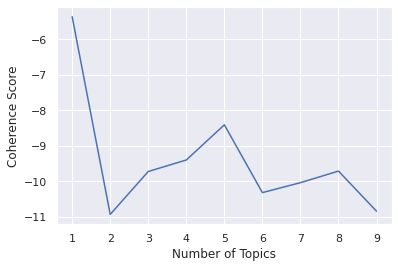

100%|██████████| 9/9 [00:26<00:00,  2.97s/it]


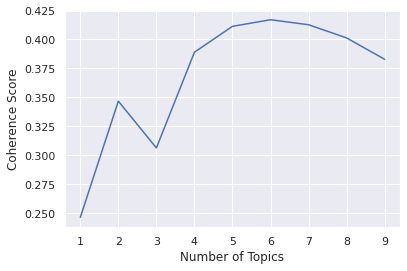

In [ ]:
# converted tokens to corpuses
# setting the model of up to 10 topics 
def lda_10_model(corpus,dictionary):
  lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)
  return(lda_model)


# obtaining the coherence scores and the coherence plots from topics 1 to 10. 
def plot_coherence_score_1(corpus,dictionary,lda_model):
  topics = []
  score = []
  for i in tqdm(range(1,10,1)):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
  _=plt.plot(topics, score)
  _=plt.xlabel('Number of Topics')
  _=plt.ylabel('Coherence Score')
  plt.show()
def plot_coherence_score_2(corpus,dictionary,lda_model): 
  topics = []
  score = []
  for i in tqdm(range(1,10,1)):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = df['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
  _=plt.plot(topics, score)
  _=plt.xlabel('Number of Topics')
  _=plt.ylabel('Coherence Score')
  plt.show()

# executing the functions above. 
tokens=token_creation(df)
df["tokens"]=tokens
dictionary=dictionary_filtering(df)
corpus=corpus_filtering(dictionary)
lda_model=lda_10_model(corpus,dictionary)
plot_coherence_score_1(corpus,dictionary,lda_model)
plot_coherence_score_2(corpus,dictionary,lda_model)


# Plotting with LDAvis

In [ ]:
# plotting the inter-topic distance plot with 5 topics
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, 'lda.html')

References: 

Ghanoum, T.: Topic modelling in python with spacy and gensim. *Towards Data Science*.  
URL: https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf 